#Thư viện

In [1]:
pip install visualkeras

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical, img_to_array, load_img
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MaxPooling2D,RandomFlip, RandomRotation,RandomZoom,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import load_model
from tensorflow.keras import Input, Model
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from shutil import copyfile
import visualkeras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Kết nối drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Tải dữ liệu

In [4]:
#https://drive.google.com/file/d/1KGvB1b5N-F44SyyvbhPi2IapLRy0pjGO/view?usp=sharing
%%shell
pip -q install --upgrade --no-cache-dir gdown
gdown -q 1KGvB1b5N-F44SyyvbhPi2IapLRy0pjGO
rm -rf ./data/
unzip -q ojects-data.zip
echo 'Data files in: data/'

Data files in: data/


#Trực quan hoá dữ liệu

In [5]:
class_names = list(filter(lambda f: os.path.isdir(os.path.join('/content/data', f)), os.listdir('/content/data')))
class_names = sorted(class_names)
num_classes = len(class_names)
print(f"Class Names: \n{class_names}")
print(f"Total Number of Classes : {num_classes}")

Class Names: 
['Boot', 'Chair', 'Laptop', 'Sofa', 'Table']
Total Number of Classes : 5


In [6]:
class_dis = [len(os.listdir('/content/data' + f"/{name}")) for name in class_names]
lk_dis = dict(zip(class_names, class_dis))
print(f"Class Distribution : \n{lk_dis}")

fig = px.pie(names=class_names, values=class_dis, width=600)
fig.update_layout({"title":{'text':"Class Distribution","x":0.5}})
fig.show()

Class Distribution : 
{'Boot': 1000, 'Chair': 1000, 'Laptop': 1000, 'Sofa': 1000, 'Table': 1000}


Found 5000 files belonging to 5 classes.


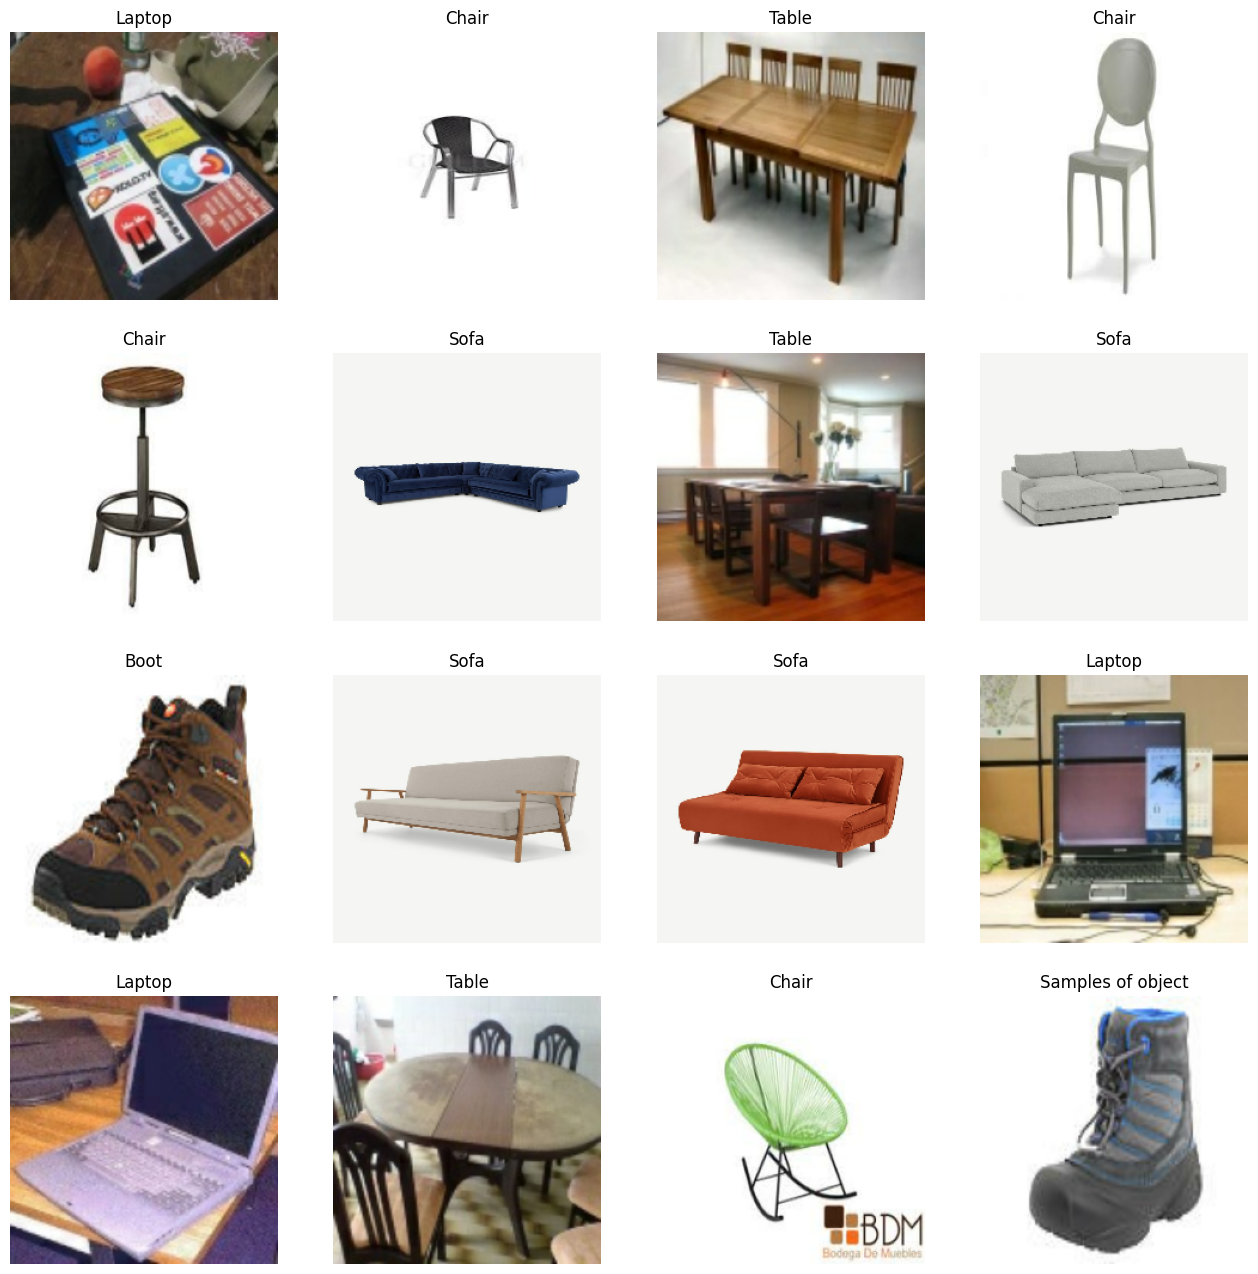

In [7]:
dataset = image_dataset_from_directory(
  '/content/data',
  image_size=(224, 224),
  batch_size=64,
  shuffle=True)

def show_images(dataset):
  plt.figure(figsize=(16,16))
  for images, labels in dataset.take(1):
    for i in range(16):
      ax = plt.subplot(4, 4, i + 1)
      ax.imshow(images[i].numpy().astype("uint8"))
      ax.set_title(dataset.class_names[labels[i]])
      ax.axis("off")
  plt.title("Samples of object")
  plt.show()

show_images(dataset)

#Huấn luyện mô hình tự tạo

In [8]:
data_directory = './data/'

data = []
labels = []

# Lặp qua từng thư mục con trong thư mục data
for label in os.listdir(data_directory):
    label_directory = os.path.join(data_directory, label)
    if os.path.isdir(label_directory):
        # Lặp qua từng tệp tin trong thư mục con và thu thập dữ liệu
        for file in os.listdir(label_directory)[:1000]:
            file_path = os.path.join(label_directory, file)
            data.append(file_path)
            labels.append(label)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)


In [9]:
def five_oject():
    model = Sequential([
        Input(shape=(224, 224, 3)),

        Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),

        Conv2D(filters=128, kernel_size=(3, 3), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),

        Flatten(name='Flatten'),

        Dense(128, activation='relu'),
        Dense(5, activation='softmax')
    ])
    return model


In [10]:
# Hàm tiền xử lý ảnh
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    return img_array

# Tiền xử lý dữ liệu ảnh trong X_train và X_test
X_train_processed = np.array([preprocess_image(img_path) for img_path in X_train])
X_test_processed = np.array([preprocess_image(img_path) for img_path in X_test])

label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

# Tạo model và huấn luyện
model = five_oject()
model.compile(loss="categorical_crossentropy",
 optimizer="adam",
 metrics=["accuracy"])

callbacks = [ModelCheckpoint(
    filepath="/content/drive/MyDrive/Projects/DeepLearning/five_object.h5",
    save_best_only=True,
    monitor="val_loss"
)]

history = model.fit(
    X_train_processed, y_train_encoded,
    epochs=10,
    validation_data=(X_test_processed, y_test_encoded),
    callbacks=callbacks
)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4779 - loss: 186.8110

110/110 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.4796 - loss: 185.5667 - val_accuracy: 0.7973 - val_loss: 0.5209
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8637 - loss: 0.3697 - val_accuracy: 0.7887 - val_loss: 0.5926
Epoch 3/10
109/110 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9311 - loss: 0.2220

110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9311 - loss: 0.2218 - val_accuracy: 0.8293 - val_loss: 0.4875
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9224 - loss: 0.2079 - val_accuracy: 0.8173 - val_loss: 0.6003
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.9260 - loss: 0.2383 - val_accuracy: 0.8353 - val_loss: 0.7618
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9780 - loss: 0.0851 - val_accuracy: 0.8387 - val_loss: 0.7524
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9803 - loss: 0.0617 - val_accuracy: 0.8347 - val_loss: 0.8139
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9961 - loss: 0.0199 - val_accuracy: 0.7940 - val_loss: 1.1322
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9814 - loss: 0.0618 - val_accuracy: 0.8093 - val_loss: 1.0545
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.9881 - loss: 0.0419 - val_accuracy: 0.

# Vẽ biểu đồ huấn luyện tự  tạo

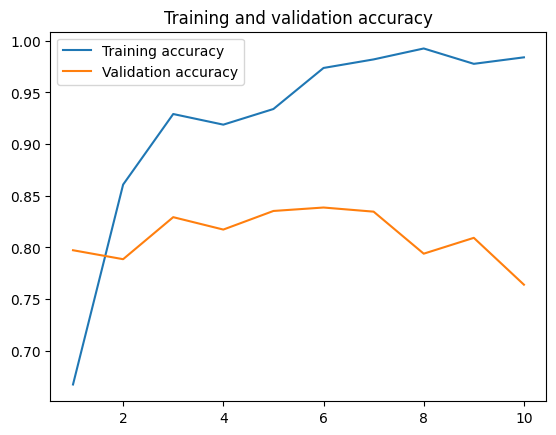

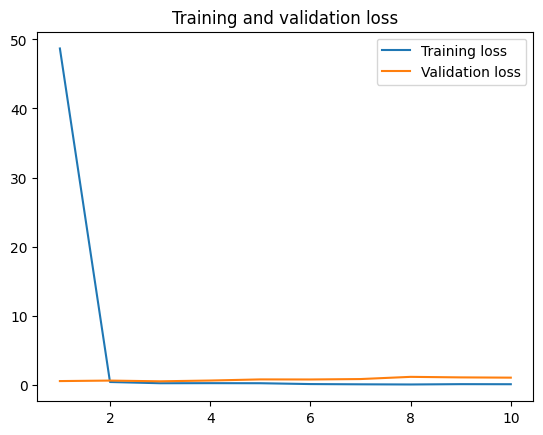

In [12]:
# Vẽ biểu đồ huấn luyện
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [13]:
# Kiểm tra mô hình
test_model = load_model("/content/drive/MyDrive/Projects/DeepLearning/five_object.h5")
test_loss, test_acc = test_model.evaluate(X_test_processed, y_test_encoded)
print(f"Test accuracy: {test_acc:.3f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8219 - loss: 0.5012
Test accuracy: 0.829


# Tách dữ liệu ra tập train , validation

In [18]:
# Thư mục chứa dữ liệu
data_dir = '/content/data'

# Thư mục chứa tập huấn luyện
!mkdir train
train_dir = '/content/train'

# Thư mục chứa tập kiểm thử
!mkdir val
val_dir = '/content/val'

# Lấy danh sách tất cả các thư mục con (nhãn)
labels = os.listdir(data_dir)

# Tạo thư mục cho tập huấn luyện và tập kiểm thử
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Chia dữ liệu và di chuyển vào thư mục tương ứng
for label in labels:
    label_path = os.path.join(data_dir, label)
    train_label_dir = os.path.join(train_dir, label)
    val_label_dir = os.path.join(val_dir, label)

    os.makedirs(train_label_dir, exist_ok=True)
    os.makedirs(val_label_dir, exist_ok=True)

    # Lấy danh sách các hình ảnh
    images = os.listdir(label_path)

    # Chia dữ liệu thành train set và val set
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Di chuyển hình ảnh vào thư mục tương ứng
    for img in train_images:
        src = os.path.join(label_path, img)
        dst = os.path.join(train_label_dir, img)
        copyfile(src, dst)

    for img in val_images:
        src = os.path.join(label_path, img)
        dst = os.path.join(val_label_dir, img)
        copyfile(src, dst)


mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘val’: File exists


#Train mô hình VGG16

In [19]:
# Số lớp (nhãn)
num_classes = 5

# Tạo và cấu hình ImageDataGenerator để tăng cường dữ liệu
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Sử dụng flow_from_directory để load dữ liệu từ thư mục con
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Sử dụng flow_from_directory để load dữ liệu từ thư mục con (tập kiểm thử)
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Tạo mô hình VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Thêm top layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile mô hình
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
model.fit(train_generator, epochs=5, validation_data=val_generator)


Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 91s 623ms/step - accuracy: 0.7690 - loss: 0.6788 - val_accuracy: 0.9460 - val_loss: 0.1871
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 554ms/step - accuracy: 0.9173 - loss: 0.2117 - val_accuracy: 0.9570 - val_loss: 0.1356
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 554ms/step - accuracy: 0.9385 - loss: 0.1703 - val_accuracy: 0.9570 - val_loss: 0.1252
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 70s 562ms/step - accuracy: 0.9539 - loss: 0.1313 - val_accuracy: 0.9500 - val_loss: 0.1311
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 69s 551ms/step - accuracy: 0.9530 - loss: 0.1228 - val_accuracy: 0.9550 - val_loss: 0.1321


In [20]:
# Đánh giá mô hình trên tập kiểm thử
eval_result_vgg16 = model.evaluate(val_generator)

# In kết quả
print(f"Test Accuracy: {eval_result_vgg16[1]}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step - accuracy: 0.9536 - loss: 0.1243
Test Accuracy: 0.9549999833106995


#Train mô hình RESNET50

In [21]:
# Tạo mô hình ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Thêm top layers
model_resnet50 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(len(labels), activation='softmax')
])

# Compile mô hình
model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
model_resnet50.fit(train_generator, epochs=5, validation_data=val_generator)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 569ms/step - accuracy: 0.4070 - loss: 1.5320 - val_accuracy: 0.6440 - val_loss: 0.8829
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 517ms/step - accuracy: 0.6540 - loss: 0.8753 - val_accuracy: 0.6160 - val_loss: 0.8321
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 65s 518ms/step - accuracy: 0.6945 - loss: 0.7483 - val_accuracy: 0.7480 - val_loss: 0.6683
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 510ms/step - accuracy: 0.7233 - loss: 0.6676 - val_accuracy: 0.7320 - val_loss: 0.6827
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 516ms/step - accuracy: 0.7113 - loss: 0.6827 - val_accuracy: 0.7590 - val_loss: 0.6037


In [22]:
# Đánh giá mô hình trên tập kiểm thử
eval_result_resnet50 = model_resnet50.evaluate(val_generator)

# In kết quả
print(f"Test Accuracy: {eval_result_resnet50[1]}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 401ms/step - accuracy: 0.7734 - loss: 0.5689
Test Accuracy: 0.753000020980835


#Lập bảng so sánh

In [23]:

# Tạo dữ liệu
data = {
    'Name': ['model','VGG16', 'RESNET50'],
    'Test accuracy': [0.845,eval_result_vgg16[1], eval_result_resnet50[1]]
}

# Tạo DataFrame từ dữ liệu và không hiển thị số thứ tự
df = pd.DataFrame(data)
df.index = [''] * len(df)  # Đặt index thành một list rỗng
print(df)


      Name  Test accuracy
     model          0.845
     VGG16          0.955
  RESNET50          0.753
